In [1]:
from pylab import *
from skimage.color import rgb2gray
from skimage.transform import rescale,resize
from torch.autograd import Variable
import torch, time,os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set the CUDA flag
cuda_flag = True
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
criterion = torch.nn.MSELoss()
epochs = 2000

losses_ = np.zeros((epochs,))

trn_ = np.zeros((epochs,))
tst_ = np.zeros((epochs,))

kk = torch.randint(512,(3,))
nd = 3
sigs = [0.01,0.002,0.0003]

signal_store = np.zeros((3,4,512))

file_path = 'images/'

In [2]:
rgb = imread('5.2.10.tiff');rgb=rgb.copy();im = rgb2gray(rgb);
signal = (torch.from_numpy(im)/256.0).type(torch.FloatTensor)

In [3]:
for i in range(nd):
    signal_store[i][0] = signal[kk[i]]

In [4]:
def srank_l12(X):
    # Get the SVD
    (u,s,v) = torch.svd(X)
    # Determine the threshold (from matrix rank)
    sr2 = (s*s).sum()/s[0]/s[0]
    sr1 = s.sum()/s[0]
    return sr1,sr2

def psnr_func(x,y):
    diff = x - y
    err = (diff*diff).flatten().mean().log10()
    return -10*err

def rff_embedding(x, b):
    rffemb = torch.cat((torch.sin((2.*np.pi*x) @ b.T),torch.cos((2.*np.pi*x) @ b.T)),1)
    rffemb = rffemb/(rffemb.norm(dim=1).max())
    return rffemb

def rbf_embedding(x,dic,sig):
    rbfemb = (-0.5*(x-dic)**2/(sig**2)).exp()
    rbfemb = rbfemb/(rbfemb.norm(dim=1).max())
    return rbfemb

In [5]:
width = 256

# Here define the MLP
class SLP(nn.Module):
    def __init__(self,input_dim):
        super(SLP, self).__init__()
        self.fco = nn.Linear(input_dim, 1)
    def forward(self, x):
        out = self.fco(x)
        return out
    def name(self):
        return "SLP"

In [6]:
sample_d=1

In [7]:
sample_N = 512
sample_d = 1
embedding_dimension = 10000

all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

train_data = all_data[::2*sample_d]
#test_data = all_data[sample_d::2*sample_d]

dic = torch.zeros((1,embedding_dimension))
for i in range(embedding_dimension):
    dic[0,i] = (i/embedding_dimension)
    
    
for i in range(3):
    sig = sigs[i]*torch.ones((1,embedding_dimension))
    xt = rbf_embedding(train_data,dic,sig).cuda()
    xt = Variable(xt)
    xts = rbf_embedding(all_data,dic,sig).cuda()

    
    for dd in range(nd):
        start_time = time.time()
        train_label = signal[kk[dd]][::2].reshape(-1,1)
        test_label = signal[kk[dd]].reshape(-1,1)

        yt = train_label.cuda()
        yt = Variable(yt)
        yts = test_label.cuda()

        # Initialize classification model to learn
        model = SLP(embedding_dimension).cuda()

        # Set the optimization
        optimizer = optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999),weight_decay=1e-8)

        for epoch in range(epochs):
            model.train()
            sum_loss = 0 # Set the average loss to zero
            optimizer.zero_grad()

            out = model(xt)
            loss = criterion(out, yt)
            loss.backward()
            sum_loss = loss.item() # Store the loss
            optimizer.step()

            losses_[epoch] = sum_loss

            model.eval()

            trn_[epoch] = psnr_func(model(xt),yt)
            tst_[epoch] = psnr_func(model(xts),yts)

        print("==>>>train psnr: %g--- , test psnr: %g--- time: %g seconds ---" 
            % (np.mean(trn_[-100:]),np.mean(tst_[-100:])
               ,time.time() - start_time))
        signal_store[dd,i+1] = model(xts).squeeze().detach().cpu()

==>>>train psnr: 27.8916--- , test psnr: 27.4829--- time: 3.21733 seconds ---
==>>>train psnr: 26.6067--- , test psnr: 26.2399--- time: 2.96946 seconds ---
==>>>train psnr: 27.2321--- , test psnr: 26.9583--- time: 2.96479 seconds ---
==>>>train psnr: 131.627--- , test psnr: 31.9091--- time: 2.97056 seconds ---
==>>>train psnr: 131.39--- , test psnr: 30.2588--- time: 3.01344 seconds ---
==>>>train psnr: 132.544--- , test psnr: 29.7396--- time: 3.01485 seconds ---
==>>>train psnr: 121.884--- , test psnr: 12.3549--- time: 2.76051 seconds ---
==>>>train psnr: 121.638--- , test psnr: 12.371--- time: 2.84412 seconds ---
==>>>train psnr: 124.853--- , test psnr: 14.9036--- time: 2.9728 seconds ---


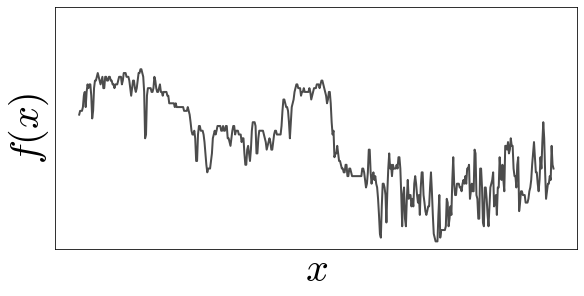

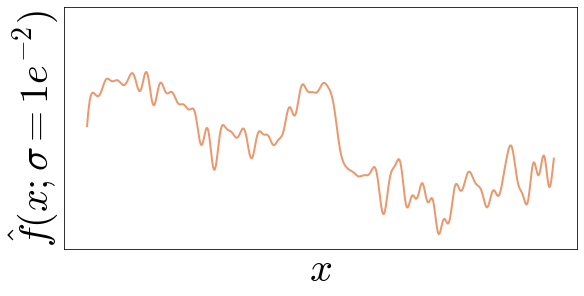

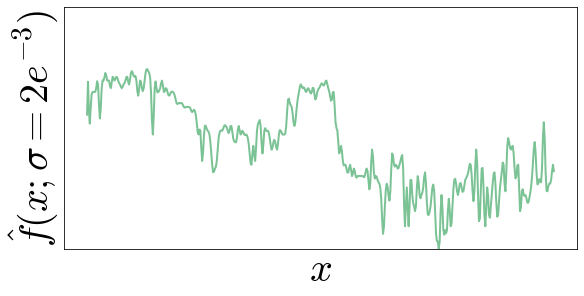

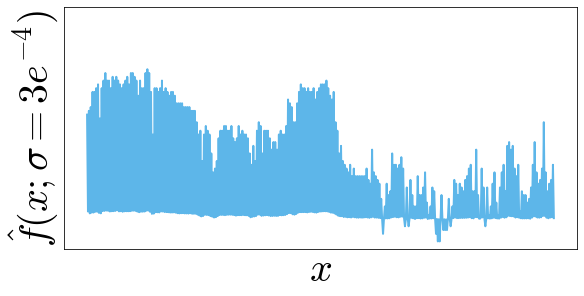

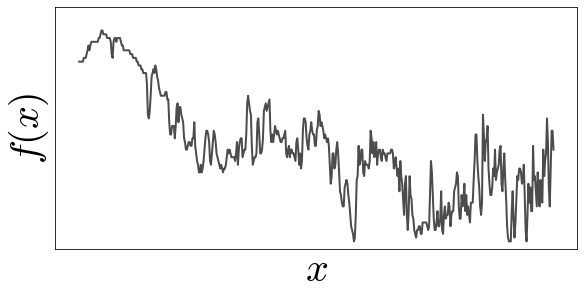

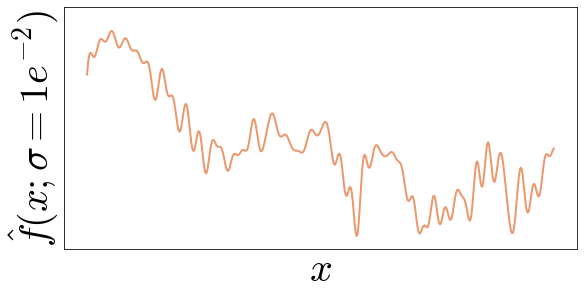

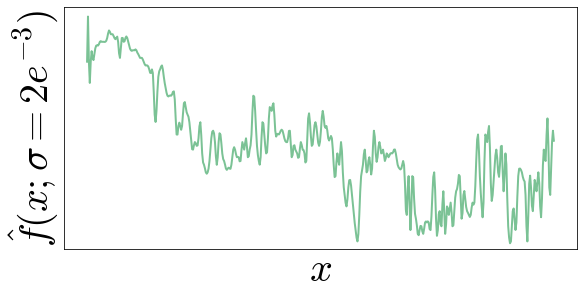

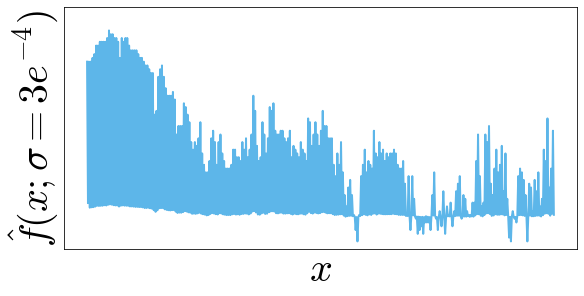

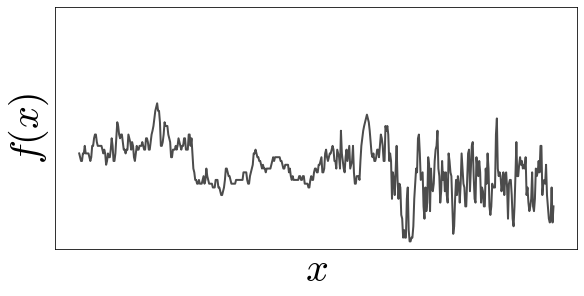

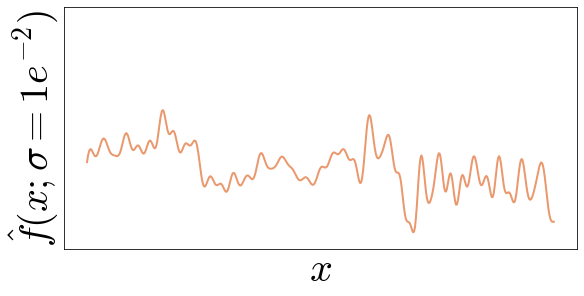

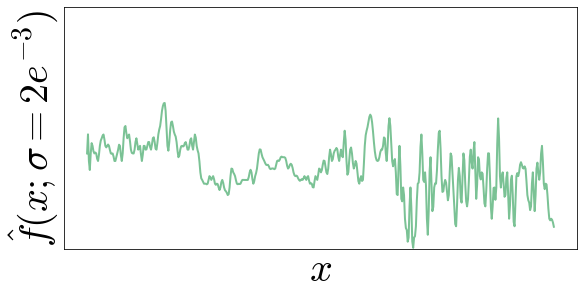

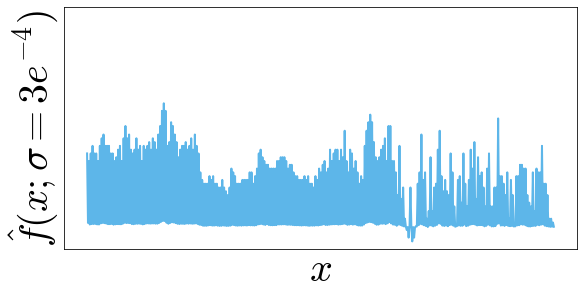

In [19]:
import matplotlib.patches as patches
import matplotlib.pylab as pylab
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 18,
         'axes.labelsize': 40,
         'axes.titlesize': 22,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"


colors_k = np.array([[0.8872, 0.4281, 0.1875],
     #[0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 2
line_alpha = .7
title_offset = -0.2

names = ['Target signal','$\sigma=1e^{-2}$','$\sigma=2e^{-3}$','$\sigma=3e^{-4}$']
file_names = ['gt','0.01','0.002','0.0003']
for i in range(3):
    for j in range(4):

        fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
        gs = fig1.add_gridspec(1, 1)
        ax = fig1.add_subplot(gs[0, 0])
        if j ==0:
            ax.plot(all_data, signal_store[i,j], label=names[j], color='k', linewidth=linewidth, alpha=line_alpha, zorder=1)
        else:
            ax.plot(all_data, signal_store[i,j], label=names[j], color=colors_k[j-1], linewidth=linewidth, alpha=line_alpha, zorder=1)
        #plt.autoscale(enable=True, axis='x', tight=True)
        ax.set_ylim(top=1,bottom=0)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.xlabel('$x$')
        if j ==0:
            plt.ylabel('$f(x)$')
        else:
            plt.ylabel('$\hat{f}(x;$'+names[j]+'$)$')
        #ax.legend(loc='lower center', ncol=2)
        plt.grid(True, which='both', alpha=.3)
        plt.savefig(file_path+'1D_'+str(i)+'_'+file_names[j]+'.pdf', bbox_inches='tight', pad_inches=0)